In [1]:
!pip install matplotlib scikit-learn

In [1]:
import torch
import random
import numpy as np

def set_seed(seed_value):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    np.random.seed(seed_value)  # Numpy module.
    random.seed(seed_value)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


set_seed(42)

In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from mimetypes import init
from pyexpat import model
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda
from torchvision import transforms
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss

import matplotlib.pyplot as plt
import random
import pdb
import argparse


class MNISTDatasetWithConcepts(Dataset):
    def __init__(self,split,num_classes,transform):
        isTrain = False
        if split == "train":
            isTrain=True
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.data = MNIST(root = "./synthetic_datasets",train=isTrain, download=True)
        self.num_classes = num_classes
        self.transform = transform
        # print(len(set([self.data[i][1] for i in range(len(self.data))])))
        self.load_data()

    def load_data(self):
        self.all_data = []
        for img, label in self.data:
            onehot = torch.zeros((self.num_classes,))
            onehot[label] =1
            concept = self.make_concepts_mnist(label)
            label = onehot.to(self.device)
            self.all_data.append([self.transform(img).to(self.device),label,concept])

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.all_data[idx]

    def make_concepts_mnist(self,label):
        if label == 0:
            hard_label = torch.tensor([1,0,0,0,0,0,0,0,0,0]+[1,0])
        elif label == 1:
            hard_label = torch.tensor([0,1,0,0,0,0,0,0,0,0]+[0,1])
        elif label == 2:
            hard_label = torch.tensor([0,0,1,0,0,0,0,0,0,0]+[1,1])
        elif label == 3:
            hard_label = torch.tensor([0,0,0,1,0,0,0,0,0,0]+[1,0])
        elif label == 4:
            hard_label = torch.tensor([0,0,0,0,1,0,0,0,0,0]+[0,1])
        elif label == 5:
            hard_label = torch.tensor([0,0,0,0,0,1,0,0,0,0]+[1,1])
        elif label == 6:
            hard_label = torch.tensor([0,0,0,0,0,0,1,0,0,0]+[1,0])
        elif label == 7:
            hard_label = torch.tensor([0,0,0,0,0,0,0,1,0,0]+[0,1])
        elif label == 8:
            hard_label = torch.tensor([0,0,0,0,0,0,0,0,1,0]+[1,0])
        elif label == 9:
            hard_label = torch.tensor([0,0,0,0,0,0,0,0,0,1]+[1,0])

        # pdb.set_trace()

        # hard_label = torch.zeros((self.num_classes,))
        # hard_label[label] = 1
        hard_label = hard_label.float().to(self.device)
        return hard_label


def load_mnist_dataloader(split,bsz):
	dataset = MNISTDatasetWithConcepts(split = split, num_classes = 10, transform=ToTensor())
	dataloader = DataLoader(dataset, batch_size=bsz, shuffle=True)
	return dataloader


In [4]:
train_loader = load_mnist_dataloader(split = "train",bsz=64)
test_loader = load_mnist_dataloader(split = "test",bsz=64)

100%|██████████| 9912422/9912422 [00:00<00:00, 181361666.90it/s]

Extracting ./synthetic_datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./synthetic_datasets/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 37306958.37it/s]


Extracting ./synthetic_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./synthetic_datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39116811.54it/s]

Extracting ./synthetic_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./synthetic_datasets/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5327329.07it/s]


Extracting ./synthetic_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./synthetic_datasets/MNIST/raw



# Models

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class g(nn.Module):
    """The network g consists of 2 convolutional
    layers with 32 channels each, along with a maxpool
    layer in between followed by a fully connected
    layer."""

    def __init__(self):
        super(g, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.fc1 = nn.Linear(800, 128)
        self.fc2 = nn.Linear(128, 14)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        non_overlapping, overlapping1, overlapping2 = x[:,:10], x[:,10:12], x[:,12:]
        return non_overlapping, overlapping1, overlapping2

class f(nn.Module):
    def __init__(self) -> None:
        super(f, self).__init__()
        self.fc1 = nn.Linear(14, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

def split_concepts(concepts):
    return concepts[:,:10], concepts[:,10:]

In [6]:
class Sequential(nn.Module):
  def __init__(self):
    super(Sequential, self).__init__()
    self.g_model = g().to(device)
    self.f_model = f().to(device)

    # Defining the training parameters for the concepts model g
    self.g_optimizer = torch.optim.Adam(self.g_model.parameters(), lr=1e-4)
    self.g_criterion = nn.CrossEntropyLoss()

    # Defining the training parameters for the prediction model f
    self.learned_g = False
    self.f_optimizer = torch.optim.Adam(self.f_model.parameters(), lr=1e-4)
    self.f_criterion = nn.CrossEntropyLoss()
    self.name = 'sequential'

  def split_concepts(self, concepts):
    return concepts[:,:10], concepts[:,10:]

  def train_g(self, train_loader, epochs):
      self.g_model.train()
      for epoch in range(epochs):
          for images, labels, concepts in train_loader:
              images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
              y_true_non_overlapping, y_true_overlapping = self.split_concepts(concepts)

              self.g_optimizer.zero_grad()
              non_overlapping, overlapping1, overlapping2 = self.g_model(images)

              # Calculate the loss for non_overlaaping concepts
              loss_non_overlapping = self.g_criterion(non_overlapping, y_true_non_overlapping.argmax(dim=1))

              # Calculate the loss for overlapping concepts
              loss_overlapping1 = self.g_criterion(overlapping1, y_true_overlapping[:,0].long())
              loss_overlapping2 = self.g_criterion(overlapping2, y_true_overlapping[:,1].long())

              # Calculate the total loss
              loss = loss_non_overlapping + loss_overlapping1 + loss_overlapping2
              loss.backward()
              self.g_optimizer.step()
          print(f"Epoch: {epoch+1}, Loss: {loss.item():.3f}")
      self.learned_g = True

  def calc_acc_non_overlapping(self, test_loader):
      self.g_model.eval()
      accuracies = []
      for images, labels, concepts in test_loader:
          images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
          y_true_non_overlapping, _ = split_concepts(concepts)
          non_overlapping, _, _ = self.g_model(images)
          y_pred_non_overlapping = non_overlapping.argmax(dim=1)
          acc =  (y_pred_non_overlapping == y_true_non_overlapping.argmax(dim=1)).float().mean().item()
          accuracies.append(acc)
      return sum(accuracies)/len(accuracies)

  def calc_acc_overlapping(self, test_loader):
      self.g_model.eval()
      accuracies = []
      for images, labels, concepts in test_loader:
          images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
          _, y_true_overlapping = split_concepts(concepts)
          _, overlapping1, overlapping2 = self.g_model(images)
          y_pred_overlapping1 = overlapping1.argmax(dim=1)
          y_pred_overlapping2 = overlapping2.argmax(dim=1)
          acc = ((y_pred_overlapping1 == y_true_overlapping[:,0]) & (y_pred_overlapping2 == y_true_overlapping[:,1])).float().mean().item()
          accuracies.append(acc)
      return sum(accuracies)/len(accuracies)

  def calc_acc_g(self, test_loader):
      self.g_model.eval()
      accuracies = []
      for images, labels, concepts in test_loader:
          images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
          y_true_non_overlapping, y_true_overlapping = split_concepts(concepts)
          non_overlapping, overlapping1, overlapping2 = self.g_model(images)
          y_pred_non_overlapping = non_overlapping.argmax(dim=1)
          y_pred_overlapping1 = overlapping1.argmax(dim=1)
          y_pred_overlapping2 = overlapping2.argmax(dim=1)
          acc = ((y_pred_non_overlapping == y_true_non_overlapping.argmax(dim=1)) & (y_pred_overlapping1 == y_true_overlapping[:,0]) & (y_pred_overlapping2 == y_true_overlapping[:,1])).float().mean().item()
          accuracies.append(acc)
      return sum(accuracies)/len(accuracies)

  def train_f(self, train_loader, epochs):
      if not self.learned_g:
        raise "You have to train g before training f in sequential training"
      self.f_model.train()
      for epoch in range(epochs):
          for images, labels, _ in train_loader:
              images, labels = images.to(device), labels.to(device)
              self.f_optimizer.zero_grad()

              non_overlapping, overlapping1, overlapping2 = self.g_model(images)
              # Concatenate the concepts
              overlapping = torch.cat([non_overlapping, overlapping1, overlapping2], dim=1)
              y_pred = self.f_model(overlapping)
              loss = self.f_criterion(y_pred, labels.argmax(dim=1))
              loss.backward()
              self.f_optimizer.step()
          print(f"Epoch: {epoch+1}, Loss: {loss.item():.3f}")

  def calc_acc_prediction(self, test_loader, delta=None):
      accuracies = []
      for images, labels, _ in test_loader:
          images, labels = images.to(device), labels.to(device)
          if delta is not None:
            y_pred = self.forward(images + delta[:images.shape[0]]).argmax(dim=1)
          else:
            y_pred = self.forward(images).argmax(dim=1)
          acc = (y_pred == labels.argmax(dim=1)).float().mean().item()
          accuracies.append(acc)
      return sum(accuracies)/len(accuracies)

  def forward(self, x):
    non_overlapping, overlapping1, overlapping2 = self.g_model(x)
    # Concatenate the concepts
    overlapping = torch.cat([non_overlapping, overlapping1, overlapping2], dim=1)
    return self.f_model(overlapping)

  def save_g(self):
    torch.save(self.g_model.state_dict(), "g_model1.pth")

  def load_g(self, path):
    self.g_model.load_state_dict(torch.load(path))
    self.learned_g = True

  def save_f(self):
    torch.save(self.f_model.state_dict(), "f_model1.pth")

  def load_f(self, path):
    self.f_model.load_state_dict(torch.load(path))

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Joint(nn.Module):
    def __init__(self):
        super(Joint, self).__init__()
        self.g_model = g().to(device)
        self.f_model = f().to(device)

        self.name = 'joint'

    def forward_training(self, x):
        non_overlapping, overlapping1, overlapping2 = self.g_model(x)
        overlapping = torch.cat([non_overlapping, overlapping1, overlapping2], dim=1)
        y_pred = self.f_model(overlapping)
        return y_pred, non_overlapping, overlapping1, overlapping2

    def forward(self, x):
        non_overlapping, overlapping1, overlapping2 = self.g_model(x)
        overlapping = torch.cat([non_overlapping, overlapping1, overlapping2], dim=1)
        y_pred = self.f_model(overlapping)
        return y_pred

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
      super(CNN, self).__init__()
      self.conv1 = nn.Conv2d(1, 32, 3, 1)
      self.conv2 = nn.Conv2d(32, 32, 3, 1)
      self.fc1 = nn.Linear(800, 128)
      self.fc2 = nn.Linear(128, 10)

      self.name = 'CNN'

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x



# Training the models

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
models_path = r"/content/drive/MyDrive/University/Thesis/Models/Adversarial training using ART"

## Training the sequential model

In [ ]:
sequential = Sequential()
sequential.train_g(train_loader, 20)
sequential.train_f(train_loader, 20)
torch.save(sequential.state_dict(), f"{models_path}/Sequential.pth")

In [11]:
sequential = Sequential()
sequential.load_state_dict(torch.load(f"{models_path}/Sequential.pth"))
sequential.calc_acc_prediction(test_loader)

0.9877587579617835

## Training the joint model

In [ ]:
pred_loss_weight, concepts_loss_weight = 0.5, 1

def calc_loss(y_pred, labels, non_overlapping, overlapping1, overlapping2, y_true_non_overlapping, y_true_overlapping, criterion, pred_loss_weight, concepts_loss_weight):

    # Calculate the loss for non_overlaaping concepts
    loss_non_overlapping = criterion(non_overlapping, y_true_non_overlapping.argmax(dim=1))
    # Calculate the loss for overlapping concepts
    loss_overlapping1 = criterion(overlapping1, y_true_overlapping[:,0].long())
    loss_overlapping2 = criterion(overlapping2, y_true_overlapping[:,1].long())
    # Calculate the loss for concepts
    concept_loss = loss_non_overlapping + loss_overlapping1 + loss_overlapping2

    # Calculate the loss for prediction
    pred_loss = criterion(y_pred, labels.argmax(dim=1))

    loss = pred_loss_weight * pred_loss + concepts_loss_weight * concept_loss
    return loss

def train_joint(model, train_loader, epochs, optimizer, criterion):
    model.train()
    for epoch in range(epochs):
        for images, labels, concepts in train_loader:
            images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
            optimizer.zero_grad()
            y_true_non_overlapping, y_true_overlapping = split_concepts(concepts)
            y_pred, non_overlapping, overlapping1, overlapping2 = model.forward_training(images)
            loss = calc_loss(y_pred, labels, non_overlapping, overlapping1, overlapping2, y_true_non_overlapping, y_true_overlapping, criterion, 1, 1)
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.3f}")


joint_model = Joint().to(device)
optimizer = torch.optim.Adam(joint_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 20
train_joint(joint_model, train_loader, epochs, optimizer, criterion)
torch.save(joint_model.state_dict(), f"{models_path}/joint_model.pth")

In [12]:
def test_joint(model, test_loader):
    model.eval()
    accuracies = []
    for images, labels, concepts in test_loader:
        images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)
        y_pred, _, _, _ = model.forward_training(images)
        acc = (y_pred.argmax(dim=1) == labels.argmax(dim=1)).float().mean().item()
        accuracies.append(acc)
    return sum(accuracies)/len(accuracies)

joint_model = Joint().to(device)
joint_model.load_state_dict(torch.load(f"{models_path}/joint_model.pth"))
test_joint(joint_model, test_loader)

0.9872611464968153

## Training the standard model

In [ ]:
cnn_model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-4)
epochs = 20

def train_cnn(model, train_loader, epochs, optimizer, criterion):
    model.train()
    for epoch in range(epochs):
        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            y_pred = model(images)
            loss = criterion(y_pred, labels.argmax(dim=1))
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.3f}")

train_cnn(cnn_model, train_loader, epochs, optimizer, criterion)

torch.save(cnn_model.state_dict(), f"{models_path}/cnn1.pth")

In [13]:
def test_cnn(model, test_loader):
  model.eval()
  accuracies = []
  for images, labels, _ in test_loader:
    images, labels = images.to(device), labels.to(device)
    y_pred = model(images).argmax(dim=1)
    acc = (y_pred == labels.argmax(dim=1)).float().mean().item()
    accuracies.append(acc)
  return sum(accuracies)/len(accuracies)


cnn_model = CNN().to(device)
cnn_model.load_state_dict(torch.load(f"{models_path}/cnn1.pth"))
test_cnn(cnn_model, test_loader)

0.9867635350318471

# Attacking the models using PGD attack

In [14]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.9 MB/s eta 0:00:00


In [15]:
import numpy as np
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
import matplotlib.pyplot as plt

def attack(model, test_loader, attack_config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Prepare test dataset
    test_data = []
    test_labels = []
    for images, labels, _ in test_loader:
        test_data.append(images)
        test_labels.append(labels.argmax(dim=1))

    test_data = torch.cat(test_data).cpu().numpy()
    test_labels = torch.cat(test_labels).cpu().numpy()

    # Define ART PyTorchClassifier
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(0, 1),
        loss=CrossEntropyLoss(),
        optimizer=torch.optim.Adam(model.parameters()),
        input_shape=(1, 28, 28),
        nb_classes=10,
    )

    # Instantiate the PGD attack
    attack = ProjectedGradientDescent(
        estimator=classifier,
        norm=np.inf,
        eps=attack_config['eps'],
        eps_step=attack_config['eps_step'],
        max_iter=attack_config['max_iter'],
        targeted=False
    )

    # Generate adversarial test examples
    adv_test_data = attack.generate(x=test_data, y=test_labels)

    # Evaluate the model on adversarial examples
    predictions = classifier.predict(adv_test_data)
    accuracy = np.sum(np.argmax(predictions, axis=1) == test_labels) / len(test_labels)

    print(f"Accuracy on adversarial examples: {accuracy*100:.2f}%")
    return accuracy*100



def visualize_attack(model, test_loader, attack_config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Convert a single batch to numpy for demonstration
    for images, labels, _ in test_loader:
        test_data = images[:1].to(device)  # Taking the first image for simplicity
        test_labels = labels[:1].argmax(dim=1).to(device)
        break

    # Convert test_data back to CPU for ART processing
    test_data_np = test_data.cpu().numpy()

    # Define ART PyTorchClassifier
    classifier = PyTorchClassifier(
        model=model,
        clip_values=(0, 1),
        loss=CrossEntropyLoss(),
        optimizer=torch.optim.Adam(model.parameters()),
        input_shape=(1, 28, 28),
        nb_classes=10,
    )

    # Instantiate the PGD attack
    attack = ProjectedGradientDescent(
        estimator=classifier,
        norm=np.inf,
        eps=attack_config['eps'],
        eps_step=attack_config['eps_step'],
        max_iter=attack_config['max_iter'],
        targeted=False
    )
    # Re-define ART classifier (assuming sequential model and classifier setup is done)
    # Generate adversarial example for the single image
    adv_test_data = attack.generate(x=test_data_np)

    # Convert adversarial data back to tensor for visualization
    adv_test_data_tensor = torch.tensor(adv_test_data).to(device)

    # Calculate delta
    delta = adv_test_data_tensor - test_data

    # Prepare for visualization
    test_data_vis = test_data.cpu().squeeze().numpy()
    delta_vis = delta.cpu().squeeze().numpy()
    adv_test_data_vis = adv_test_data_tensor.cpu().squeeze().numpy()

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(test_data_vis, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(delta_vis, cmap='gray')
    axs[1].set_title('Delta')
    axs[1].axis('off')

    axs[2].imshow(adv_test_data_vis, cmap='gray')
    axs[2].set_title('Adversarial Image')
    axs[2].axis('off')

    plt.show()

def attack_and_visualize(model, test_loader, attack_config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Prepare test dataset for a single example
    for images, labels, _ in test_loader:
        test_data = images[:1].to(device)
        test_labels = labels[:1].to(device)
        break

    test_data_np = test_data.cpu().numpy()

    classifier = PyTorchClassifier(
        model=model,
        clip_values=(0, 1),
        loss=CrossEntropyLoss(),
        optimizer=torch.optim.Adam(model.parameters()),
        input_shape=(1, 28, 28),
        nb_classes=10,
    )

    attack = ProjectedGradientDescent(
        estimator=classifier,
        norm=np.inf,
        eps=attack_config['eps'],
        eps_step=attack_config['eps_step'],
        max_iter=attack_config['max_iter'],
        targeted=False
    )

    adv_test_data = attack.generate(x=test_data_np)
    adv_test_data_tensor = torch.tensor(adv_test_data).to(device)

    delta = adv_test_data_tensor - test_data

    # Predictions
    model.eval()
    with torch.no_grad():
        original_pred = model(test_data).argmax(dim=1)
        adversarial_pred = model(adv_test_data_tensor).argmax(dim=1)

    # Visualization
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(test_data.cpu().squeeze().numpy(), cmap='gray')
    axs[0].set_title(f'Original\nPred: {original_pred.item()}')
    axs[0].axis('off')

    axs[1].imshow(delta.cpu().squeeze().numpy(), cmap='gray')
    axs[1].set_title('Delta')
    axs[1].axis('off')

    axs[2].imshow(adv_test_data_tensor.cpu().squeeze().numpy(), cmap='gray')
    axs[2].set_title(f'Adversarial\nPred: {adversarial_pred.item()}')
    axs[2].axis('off')

    plt.show()

In [16]:
attack_config = dict(
    eps=0.1,
    eps_step=0.01,
    max_iter=20
)

## Attacking the sequential model

In [ ]:
attack(sequential, test_loader, attack_config)

PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 71.39%


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

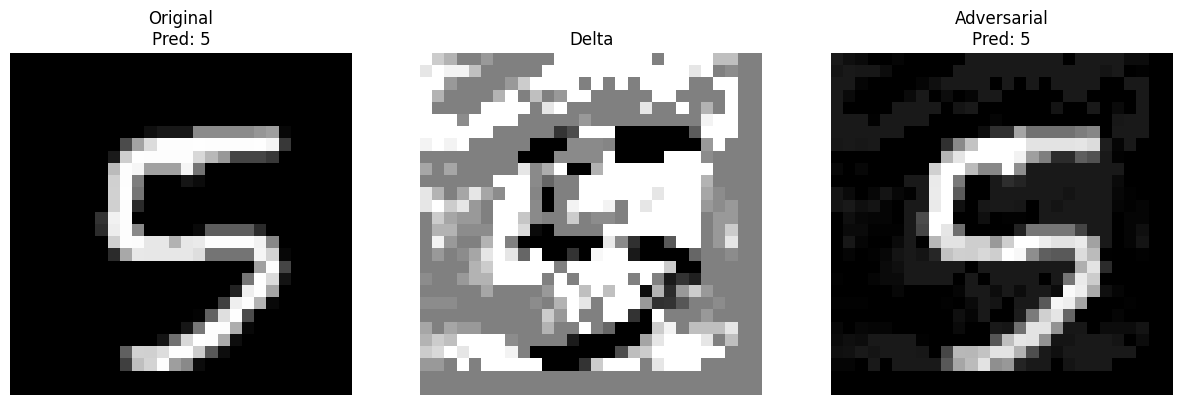

In [ ]:
attack_and_visualize(sequential, test_loader, attack_config)

## Attacking the joint model

In [ ]:
attack(joint_model, test_loader, attack_config)

PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 69.86%


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

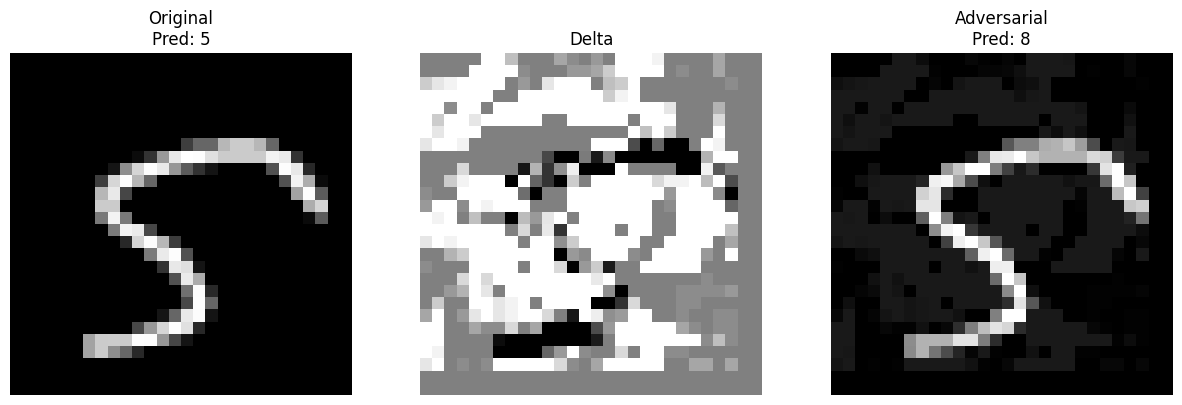

In [ ]:
attack_and_visualize(joint_model, test_loader, attack_config)

## Attacking the standard model

In [ ]:
attack(cnn_model, test_loader, attack_config)

PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 71.36%


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

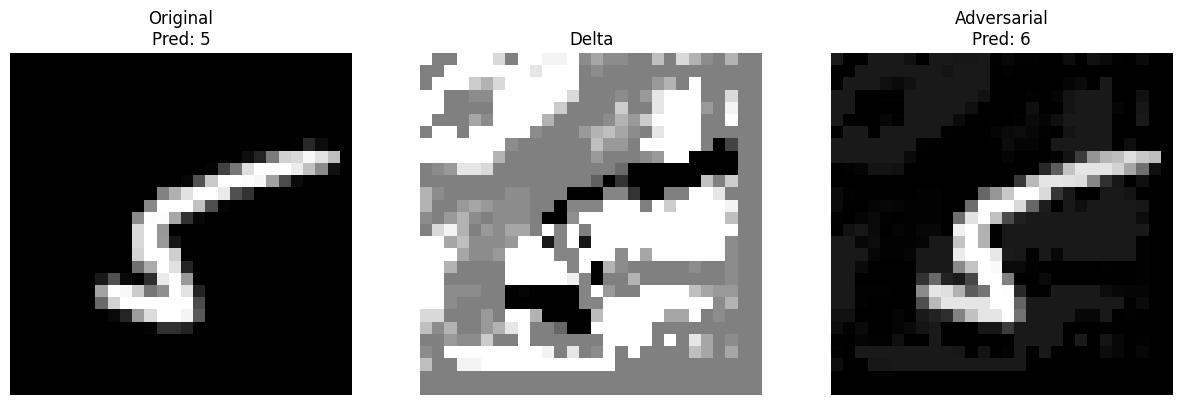

In [ ]:
attack_and_visualize(cnn_model, test_loader, attack_config)

## Attacking with different values of eps

sequential 0.05


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 93.76%
joint 0.05


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 93.14%
CNN 0.05


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 93.87%
sequential 0.1


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 71.39%
joint 0.1


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 69.86%
CNN 0.1


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 71.36%
sequential 0.2


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 10.21%
joint 0.2


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 8.06%
CNN 0.2


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 6.54%
sequential 0.3


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 10.21%
joint 0.3


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 8.07%
CNN 0.3


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 6.54%
sequential 0.4


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 10.21%
joint 0.4


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 8.06%
CNN 0.4


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 6.54%


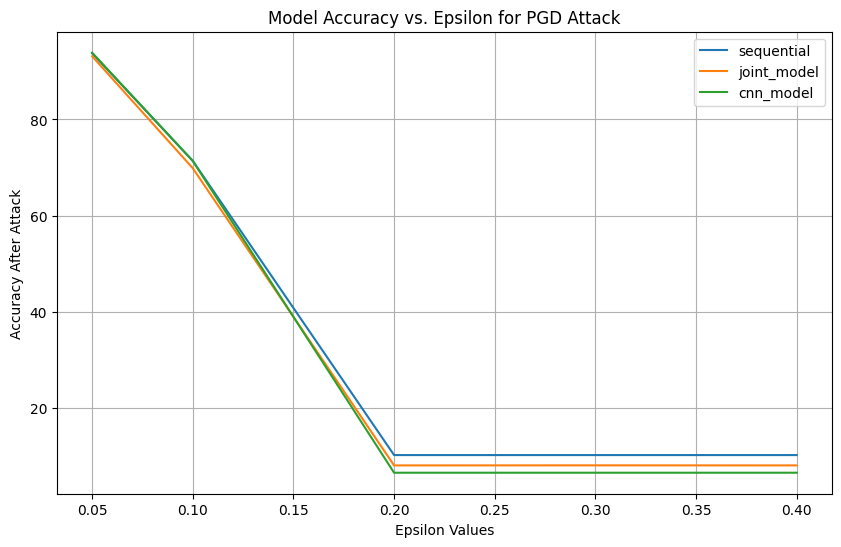

In [ ]:
import matplotlib.pyplot as plt

# Define a range of epsilon values
eps_values = [0.05, 0.1, 0.2, 0.3, 0.4]

# Initialize a dictionary to store accuracies for each model
accuracies = {'sequential': [], 'joint_model': [], 'cnn_model': []}

# Define your models here
models = {'sequential': sequential, 'joint_model': joint_model, 'cnn_model': cnn_model}

for eps in eps_values:
    # Update attack_config with the current eps value
    attack_config['eps'] = eps
    for model_name, model in models.items():
        # Execute the attack
        print(model.name, eps)
        accuracy = attack(model, test_loader, attack_config)
        # Store the accuracy
        accuracies[model_name].append(accuracy)

# Plotting the results
plt.figure(figsize=(10, 6))
for model_name, acc_list in accuracies.items():
    plt.plot(eps_values, acc_list, label=model_name)

plt.xlabel('Epsilon Values')
plt.ylabel('Accuracy After Attack')
plt.title('Model Accuracy vs. Epsilon for PGD Attack')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
accuracies

{'sequential': [93.76,
  71.39,
  10.209999999999999,
  10.209999999999999,
  10.209999999999999],
 'joint_model': [93.14, 69.86, 8.06, 8.07, 8.06],
 'cnn_model': [93.87, 71.36, 6.54, 6.54, 6.54]}

# Adversarially training the models

I will train each model with different values of eps and test it with all the other epsilons

In [41]:
from art.defences.trainer import AdversarialTrainer

def adversarial_training(model, train_loader, test_loader, attack_config, model_path):
    train_data = []
    train_labels = []

    for images, labels, _ in train_loader:
        train_data.append(images)
        train_labels.append(labels.argmax(dim=1))

    train_data = torch.cat(train_data).cpu().numpy()
    train_labels = torch.cat(train_labels).cpu().numpy()
    # Prepare test dataset
    test_data = []
    test_labels = []
    for images, labels, _ in test_loader:
        test_data.append(images)
        test_labels.append(labels.argmax(dim=1))

    test_data = torch.cat(test_data).cpu().numpy()
    test_labels = torch.cat(test_labels).cpu().numpy()

    classifier = PyTorchClassifier(
        model=model,
        clip_values=(0, 1),
        loss=CrossEntropyLoss(),
        optimizer=torch.optim.Adam(model.parameters()),
        input_shape=(1, 28, 28),
        nb_classes=10,
        )

    attack = ProjectedGradientDescent(
        estimator=classifier,
        norm=np.inf,
        eps=attack_config['eps'],
        eps_step=attack_config['eps_step'],
        max_iter=attack_config['max_iter'],
        targeted=False,
    )
    # Checking the adversarial accuracy before the adversarial training
    adv_test_data_before_training = attack.generate(x=test_data, y=test_labels)

    # Evaluate the model on the adversarial examples
    predictions_before_training = classifier.predict(adv_test_data_before_training)
    accuracy_before_training_on_adv = np.sum(np.argmax(predictions_before_training, axis=1) == test_labels) / len(test_labels)
    print(f"Accuracy on adversarial examples before adversarial training: {accuracy_before_training_on_adv*100:.2f}%")

    # Adversarial training
    adv_trainer = AdversarialTrainer(classifier, attacks=attack, ratio=1.0)
    adv_trainer.fit(x=train_data, y=train_labels, nb_epochs=3)

    # After adversarial training, evaluate the model on the original test set
    predictions = classifier.predict(test_data)
    accuracy_after_training = np.sum(np.argmax(predictions, axis=1) == test_labels) / len(test_labels)
    print(f"Accuracy on original examples after adversarial training: {accuracy_after_training*100:.2f}%")

    # Attack the model again after adversarial training
    adv_test_data_after_training = attack.generate(x=test_data, y=test_labels)

    # Evaluate the model on the new adversarial examples
    predictions_after_training = classifier.predict(adv_test_data_after_training)
    accuracy_after_training_on_adv = np.sum(np.argmax(predictions_after_training, axis=1) == test_labels) / len(test_labels)
    print(f"Accuracy on adversarial examples after adversarial training: {accuracy_after_training_on_adv*100:.2f}%")

    torch.save(classifier.model.state_dict(), model_path)

    return accuracy_before_training_on_adv, accuracy_after_training, accuracy_after_training_on_adv

In [ ]:
import pandas as pd

models = ['Sequential', 'joint_model', 'cnn1']
models_classes = {'Sequential': Sequential, 'joint_model': Joint, 'cnn1': CNN}
models_path = r"/content/drive/MyDrive/University/Thesis/Models/Adversarial training using ART"
save_models_path = r"/content/drive/MyDrive/University/Thesis/Models/Adversarial training using ART/adversarially trained"
csv_file_path = r"/content/drive/MyDrive/University/Thesis/Models/Adversarial training using ART/experiments.csv"
attack_config = dict(
    eps_step=0.01,
    max_iter=20
)

eps_values = [0.05, 0.1, 0.2, 0.3, 0.4]
experiment = {
    'model_name': [],
    'training eps': [],
    'accuracy_before_training_on_adv': [],
    'accuracy_after_training_on_normal': [],
    'accuracy_after_training_on_adv': [],
    'accuracy with eps 0.05': [],
    'accuracy with eps 0.1': [],
    'accuracy with eps 0.2': [],
    'accuracy with eps 0.3': [],
    'accuracy with eps 0.4': [],
}
for model_name in models:
  for eps in eps_values:
    model = models_classes[model_name]()
    model.load_state_dict(torch.load(f"{models_path}/{model_name}.pth"))
    model_path = f"{save_models_path}/{model_name}_{str(eps).split('.')[1]}.pth"
    print(f'Loaded {model_name}')
    print(f"Training with eps {eps}")
    attack_config['eps'] = eps
    accuracy_before_training_on_adv, accuracy_after_training, accuracy_after_training_on_adv = adversarial_training(model, train_loader, test_loader, attack_config, model_path)

    # saving the information that we have so far
    experiment['model_name'] = model_name
    experiment['training eps'] = eps
    experiment['accuracy_before_training_on_adv'] = accuracy_before_training_on_adv
    experiment['accuracy_after_training_on_normal'] = accuracy_after_training
    experiment['accuracy_after_training_on_adv'] = accuracy_after_training_on_adv

    # loading the trained model
    trained_model = models_classes[model_name]()
    trained_model.load_state_dict(torch.load(model_path))
    trained_model.to(device)

    # testing the trained model with different values of eps:
    for second_eps in eps_values:
      attack_config['eps'] = second_eps
      second_eps_accuracy = attack(trained_model, test_loader, attack_config)
      experiment[f'accuracy with eps {second_eps}'] = second_eps_accuracy


Loaded Sequential
Training with eps 0.05


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples before adversarial training: 93.76%


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy on original examples after adversarial training: 99.00%
Accuracy on adversarial examples after adversarial training: 97.12%


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 97.12%


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 91.75%


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 50.00%


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 50.00%


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 50.00%
Loaded Sequential
Training with eps 0.1


PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples before adversarial training: 71.39%


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/3 [00:00<?, ?it/s]

In [38]:
df = pd.DataFrame(data=experiment)
df.to_csv(csv_file_path, index=False)
df
experiment

{'model_name': 'Sequential',
 'training eps': 0.05,
 'accuracy_before_training_on_adv': [],
 'accuracy_after_training_on_normal': [],
 'accuracy_after_training_on_adv': [],
 'accuracy with eps 0.05': 93.76,
 'accuracy with eps 0.1': 71.39,
 'accuracy with eps 0.2': [],
 'accuracy with eps 0.3': [],
 'accuracy with eps 0.4': []}

In [17]:
attack_config = dict(
    eps=0.2,
    eps_step=0.01,
    max_iter=20
)
adversarial_training(sequential, train_loader, test_loader, attack_config)

PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples before adversarial training: 10.21%


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy on original examples after adversarial training: 98.21%
Accuracy on adversarial examples after adversarial training: 86.11%


In [18]:
attack_config = dict(
    eps=0.4,
    eps_step=0.01,
    max_iter=20
)
adversarial_training(sequential, train_loader, test_loader, attack_config)

PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples before adversarial training: 86.11%


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Accuracy on original examples after adversarial training: 98.63%
Accuracy on adversarial examples after adversarial training: 90.65%


In [19]:
attack_config = dict(
    eps=0.1,
    eps_step=0.01,
    max_iter=20
)
attack(sequential, test_loader, attack_config)

PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial examples: 96.20%


96.2